**ETHERIUM (ETH)**

**Project Title: FutureCoin: Machine Learning-Based Crypto Price Prediction**

**1. Project Statement and Outcomes:**

1.The Cryptocurrency Price Prediction Using Machine Learning project aims to predict future cryptocurrency prices using time-series forecasting. The system will preprocess historical data, build predictive models, and visualize trends to offer valuable insights into future price movements.


2.A system that accurately predicts future cryptocurrency prices using time-series forecasting. It will offer valuable insights into market trends by analyzing historical data and visualizing predicted price movements, helping users make informed decisions in the cryptocurrency market.



**Milestone 2:**
Week 3-4: Modal Architecture, Training, Evaluation:


● Identify and create relevant features for time-series forecasting (e.g., moving averages, rolling statistics).

● Train machine learning models for time-series forecasting to predict future prices.

● Tune hyperparameters and validate model performance using standard metrics like MSE and MAE.

XGBoost Regression with Technical Indicators
--------------------------------------------
MAE  : 1.1733
RMSE : 1.5313
R²   : 0.9993


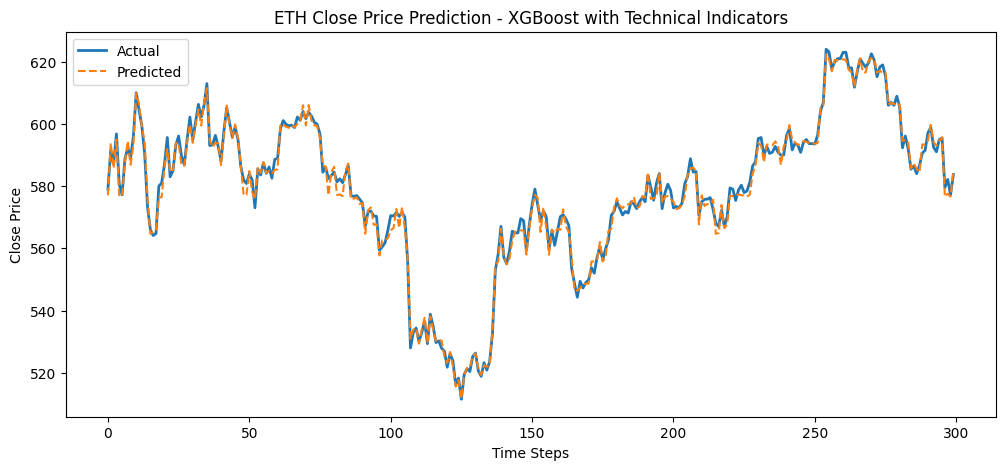

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# -----------------------------
# 1️⃣ Load and Clean Data
# -----------------------------
csv_path = '/content/ETHUSDT_1h_2017_2025.csv'
df = pd.read_csv(csv_path)

# Drop unnecessary columns
for col in ['Ignore', 'Close Time']:
    if col in df.columns:
        df.drop(columns=[col], inplace=True)

# Convert timestamps
df['Open Time'] = pd.to_datetime(df['Open Time'], errors='coerce')
df.dropna(subset=['Open Time'], inplace=True)
df.ffill(inplace=True)
df.drop_duplicates(inplace=True)
df.set_index('Open Time', inplace=True)

# -----------------------------
# 2️⃣ Feature Engineering
# -----------------------------
# Basic features
df['HL_PCT'] = (df['High'] - df['Low']) / df['Close'] * 100
df['PCT_change'] = (df['Close'] - df['Open']) / df['Open'] * 100

# EMA
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# RSI
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['MACD_signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# Bollinger Bands
df['BB_mid'] = df['Close'].rolling(window=20).mean()
df['BB_std'] = df['Close'].rolling(window=20).std()
df['BB_upper'] = df['BB_mid'] + 2 * df['BB_std']
df['BB_lower'] = df['BB_mid'] - 2 * df['BB_std']

df.dropna(inplace=True)  # drop rows with NaN from indicators

# -----------------------------
# 3️⃣ Features & Target
# -----------------------------
feature_cols = [
    'Open','High','Low','Close','Volume',
    'HL_PCT','PCT_change',
    'EMA_10','EMA_50',
    'RSI','MACD','MACD_signal',
    'BB_mid','BB_upper','BB_lower'
]

X = df[feature_cols].values
y = df['Close'].values  # predicting actual close price

# Scale features and target
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(y.reshape(-1,1))

# -----------------------------
# 4️⃣ Train-Test Split
# -----------------------------
split = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

# -----------------------------
# 5️⃣ Train XGBoost Regressor
# -----------------------------
model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

model.fit(X_train, y_train.ravel())

# -----------------------------
# 6️⃣ Predict and Inverse Transform
# -----------------------------
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1,1))
y_test_actual = target_scaler.inverse_transform(y_test)

# -----------------------------
# 7️⃣ Evaluate
# -----------------------------
mae = mean_absolute_error(y_test_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
r2 = r2_score(y_test_actual, y_pred)

print("XGBoost Regression with Technical Indicators")
print("--------------------------------------------")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"R²   : {r2:.4f}")

# -----------------------------
# 8️⃣ Plot Actual vs Predicted
# -----------------------------
plt.figure(figsize=(12,5))
plt.plot(y_test_actual[:300], label="Actual", linewidth=2)
plt.plot(y_pred[:300], label="Predicted", linestyle="dashed")
plt.title("ETH Close Price Prediction - XGBoost with Technical Indicators")
plt.xlabel("Time Steps")
plt.ylabel("Close Price")
plt.legend()
plt.show()
